# Extracted MPPT plotting function

This notebook contains a standalone extraction of the MPPT plotting function from `plotter_widget.py` (GUI). It provides a `plot_mppt` function that accepts a matplotlib `ax` and a list of CSV file paths, plus a convenience wrapper `create_mppt_plot` that returns a figure/axis for display.

Notes:
- The function is a direct, self-contained port of `_plot_mppt` from `gui/results_viewer/plotter_widget.py` but modified to plot a single trial at a time and to give each trace (pixel) a distinct color.
- It expects CSV files in the same format used by the original GUI (metadata rows above a header row that contains `Time`, then data columns).
- Example usage is provided; adjust file glob/path to point at real CSVs on your system.

In [19]:
import os
import re
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties

def plot_mppt(ax, csv_files, plot_title, data_type="pce"):
    """
    Plot MPPT timeseries data on the provided matplotlib axis.

    This version plots only a single trial (the first CSV in `csv_files`) and assigns a distinct color
    to each trace (pixel) from that trial.

    Args:
        ax: matplotlib axis object
        csv_files: list of CSV file paths (only the first file will be used)
        plot_title: title for the plot
        data_type: "pce", "voltage", or "current"
    """
    if not csv_files:
        raise ValueError("No CSV files provided to plot_mppt")

    # Use only the first trial/file
    if len(csv_files) > 1:
        print("plot_mppt: multiple files provided — using the first file only")
    csv_file = csv_files[0]

    # Load file
    arr = np.loadtxt(csv_file, delimiter=",", dtype=str)
    header_row = np.where(arr == "Time")[0][0]

    # Extract metadata (rows above header)
    meta_data = {}
    for data in arr[:header_row, :2]:
        if len(data) >= 2:
            meta_data[data[0]] = data[1]

    headers = arr[header_row, :]
    arr = arr[header_row + 1 :, :]
    header_dict = {value: index for index, value in enumerate(headers)}

    # Original GUI expects interleaved V/mA columns and uses first 8 pixels
    pixel_V = arr[:, 1::2][:, 0:8].astype(float)
    pixel_mA = arr[:, 2::2][:, 0:8].astype(float)
    time = np.array(arr[:, header_dict["Time"]]).astype(float)
    if len(time) < 1:
        raise ValueError("No time data found in CSV")

    # Calculate data based on requested type
    if data_type == "pce":
        cell_area = float(meta_data.get("Cell Area (mm^2)", 128.0))
        # Convert to percent PCE
        data = ((pixel_V * pixel_mA / 1000) / (0.1 * cell_area)) * 100
        y_label = "PCE [%]"
    elif data_type == "voltage":
        data = pixel_V
        y_label = "Voltage [V]"
    elif data_type == "current":
        cell_area = float(meta_data.get("Cell Area (mm^2)", 128.0))
        data = pixel_mA / (0.1 * cell_area)  # mA/cm^2
        y_label = "Current Density [mA/cm^2]"
    else:
        raise ValueError(f"Invalid data_type: {data_type}. Must be 'pce', 'voltage', or 'current'")

    # Downsample if very large
    if len(time) > 5000:
        step = int(np.ceil(len(time) / 5000))
        time = time[::step]
        data = data[::step, :]

    # Convert seconds -> minutes
    time = time / 60.0

    # Determine whether to display minutes or hours
    overall_max_time = float(np.max(time))
    if overall_max_time > 60:
        # convert minutes -> hours for plotting
        time = time / 60.0
        time_label = "Time [hrs]"
        overall_max_time = overall_max_time / 60.0
    else:
        time_label = "Time [min]"

    overall_max_value = float(np.max(data))

    # Plot each pixel with its own color (distinct per trace)
    NUM_PIXELS = data.shape[1]
    if NUM_PIXELS <= 10:
        pixel_colors = plt.cm.tab10(np.linspace(0, 1, NUM_PIXELS))
    else:
        pixel_colors = plt.cm.hsv(np.linspace(0, 1, NUM_PIXELS, endpoint=False))

    for i in range(NUM_PIXELS):
        basename = os.path.basename(csv_file)
        match = re.search(r"ID(\d+)", basename, re.IGNORECASE)
        id_str = match.group(1) if match else ""
        label_suffix = f" (ID {id_str})" if id_str else ""
        lineName = f"Pixel {i+1}{label_suffix}"
        color = pixel_colors[i % len(pixel_colors)]
        ax.plot(time, data[:, i], label=lineName, color=color)

    # Set axes limits and labels
    ax.set_xlim(0, overall_max_time * 1.01)
    ax.set_ylim(0, overall_max_value * 1.15)
    ax.set_title(plot_title)
    ax.set_xlabel(time_label)
    ax.set_ylabel(y_label)
    ax.grid(True)

def create_mppt_plot(csv_files, plot_title="MPPT Plot", data_type="pce"):
    """Convenience wrapper: create figure & axis, call plot_mppt, add legend, and return (fig, ax)."""
    fig, ax = plt.subplots(tight_layout=True)
    plot_mppt(ax, csv_files, plot_title, data_type)
    # Add legend; for many lines this can be large -- adjust as needed
    ax.legend(loc="upper right", fontsize="small", ncol=1)
    return fig, ax


## Example usage

Adjust the path/glob to point to your MPPT CSV files. The example below is ready to call with a single CSV path (single trial).

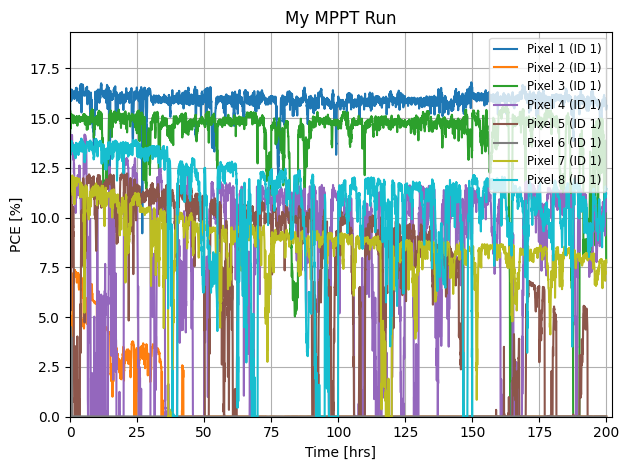

Edit the example cell to point at your single MPPT CSV file, then uncomment & run the example.


In [20]:
from glob import glob

# Example: point to a single MPPT CSV file (single trial)
# csv_files = [r"C:\path\to\your\Combined__ID1__mppt.csv"]
fig, ax = create_mppt_plot([rf"C:\Users\achen\Dropbox\code\Stability-Setup\data\July-30-2025 long stability\Combined__ID1__mppt.csv"], "My MPPT Run", data_type="pce")
plt.show()

print("Edit the example cell to point at your single MPPT CSV file, then uncomment & run the example.")